<style>
body, .rendered_html, .CodeMirror, .output {
    font-family: "Courier New", monospace;
    font-size: 16px;
}
</style>


## ORFEUS webinar

# How to curate and check seismic station metadata
31 May 2024


# 1. Metadata curation
___

## Typical workflow for a network curator for metadata updates
- Mostly manual work
- Variety of exceptions to cover
- Metadata is critical
- SCML preferred (no conversion)

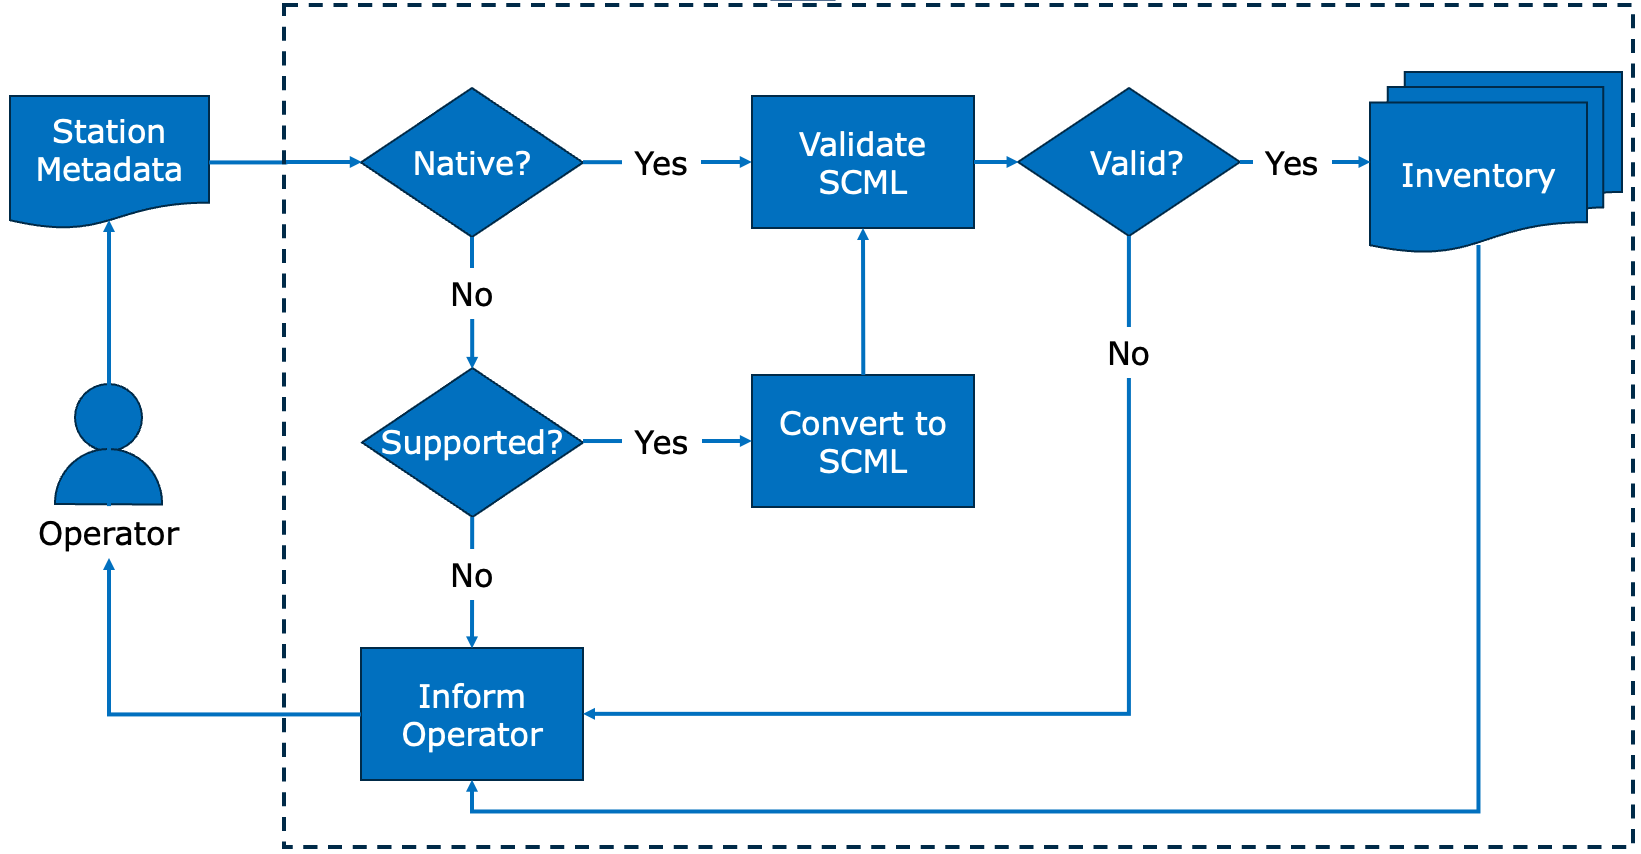

## Tools
There is a pool of tools available for maintaining metadata, for example:

- [NRL](https://ds.iris.edu/ds/nrl/) - *Build your own response*
- [ObsPy](https://docs.obspy.org) - *Python framework for processing seismological data, supports various metadataformats, open-source*
- [gempa: Station Management Portal](https://smp.gempa.de/) - *Online metadata management portal, only supports SCML*
- [Yasmine](https://github.com/iris-edu/yasmine-stationxml-editor) - *Python web application to create and edit geophysical station metadata information in FDSN stationXML format*

## Metadata formats

<br/>

- SeisComP native
  - SCML 0.11, 0.12, 0.13 (depending on SeisComP version)
- Nonnative (conversion to SCML required before uploading to the inventory):
  - StationXML 1.1, 1.2
  - Dataless SEED (preferrably not)

<br/>

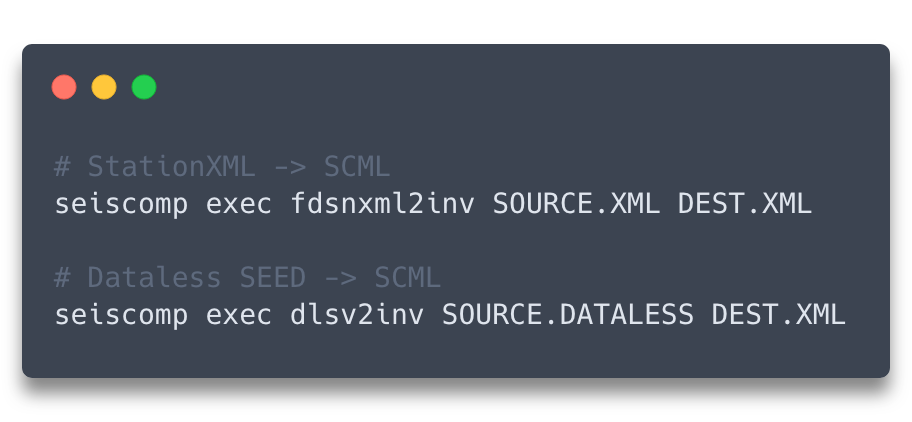

<br/>
<br/>

## Validation
### Validation using SeisComP (OK)

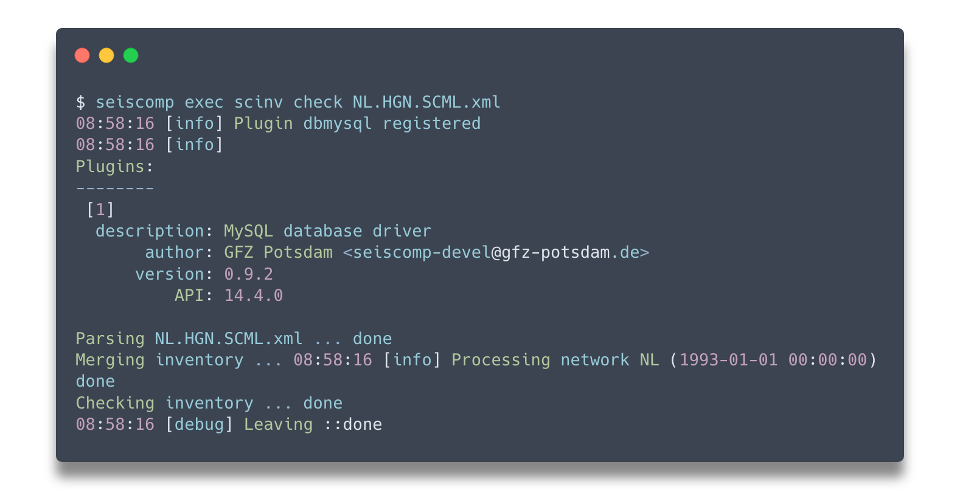

### Validation using SeisComP (Not OK)
Start time of NL.HGN.BHE channel is later than end time.

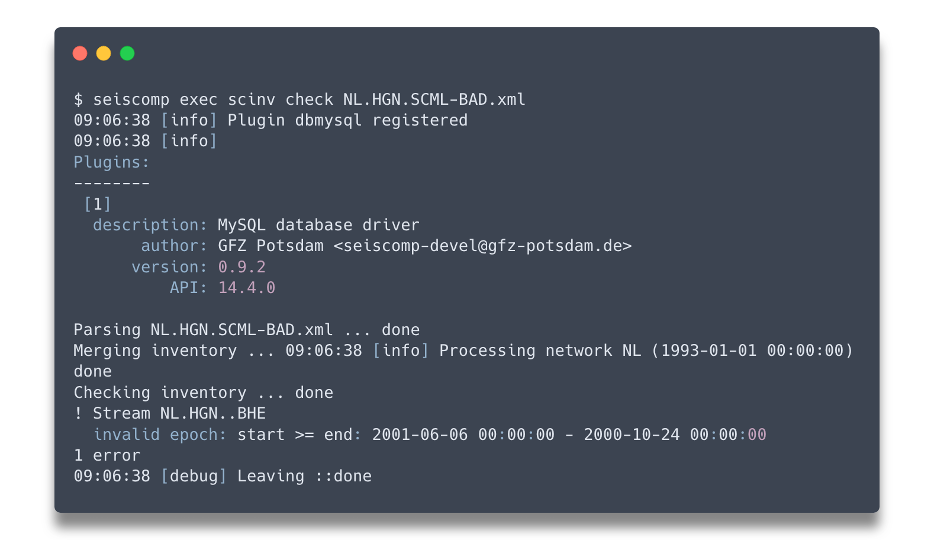

### Validation using python/xmlschema

In [1]:
import xmlschema
if xmlschema.is_valid("./data/good_example.xml", "./data/fdsn-station-1.2.xsd"):
    print("Valid StationXML!")

Valid StationXML!


In [2]:
if xmlschema.is_valid("./data/bad_example.xml", "./data/fdsn-station-1.2.xsd"):
    print("Valid StationXML!")
else:
    try:
        xmlschema.validate("./data/bad_example.xml", "./data/fdsn-station-1.2.xsd")
    except xmlschema.XMLSchemaValidationError as validation_error:
        print(validation_error)

failed validating {'startDate': '2002-11-19T21:07:00Z'} with XsdAttributeGroup(['alternateCode', 'code', 'endDate', 'historicalCode', 'restrictedStatus', 'sourceID', 'startDate', XsdAnyAttribute(namespace=['##other'], process_contents='lax')]):

Reason: missing required attribute 'code'

Schema component:

  <xs:extension xmlns:xs="http://www.w3.org/2001/XMLSchema" base="fsx:BaseNodeType">
              <xs:sequence>
                  <xs:element name="Latitude" type="fsx:LatitudeType">
                      <xs:annotation>
      <xs:documentation>Station latitude, in degrees. Where the bulk of the equipment is located (or another appropriate site location).
    The unit is fixed to be degrees, and datum defaults to WGS84.
  </xs:documentation>
      <xs:documentation><example><Latitude>34.9459</Latitude></example></xs:documentation>
                      </xs:annotation>
                  </xs:element>
                  <xs:element name="Longitude" type="fsx:LongitudeType">
          

## How to mantain network quality
- In general QC parameters (TODO: What to add here still?)
- Teleseismic events should have similar earth response at similar stations after instrument response removal (Ask Elmer for plot of amplitudes with faulty gain settions for instance)
- Single frequency over time of PPSD to check effect of response change


## Responsibilities of network curator
- Only validation of metadata
  - technical details are maintained by the metadata operator
- For best practice, check for instance the seed manual
- For EIDA: As long as the xml is valid, it is accepted

## Example of problematic metadata: Raspberry Shake
- Sensors get fixed seed id and are subsequently move to new locations
- Difficult to keep track of history of sensor and usability of data

# 2. Station Metadata Changelog API
___

Practical and simple way to log and publish metadata changes.

Two parts
- Harvester: logs metadata changes of datacenter FDSNWS
- API: Returns metadata changes and timeline

## Harvester – A very basic outline 

- Periodically checks datacenter FDSNWS
- Requirements:
    - FDSNWS-Station
    - Network DOI



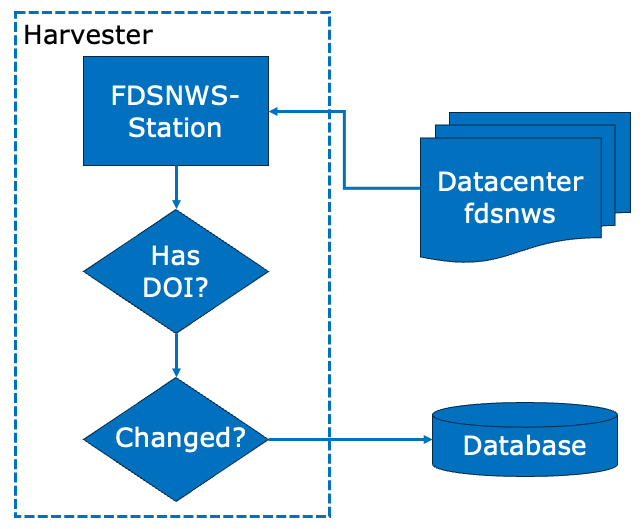

## API - Methods
- Query
    - Get station metadata changelog in a given time-window
- Metadata
    - Get station metadata at given timestamp
- Timeline
    - Get station metadata timeline

Changelog is created on request, based on metadata saved in database
- flexibility to adapt changelog exporting format for each agency
- the only data stored is station metadata (in StationXML)
- very simple codebase

## Example: Station Metadata Changelog API request

In [10]:
import requests
from requests.adapters import HTTPAdapter

# Create http session
session = requests.Session()
session.mount("http://", HTTPAdapter())

In [2]:
# Request timeline of network
api_timeline_url = 'https://changelog-odc.sa.acc.knmi.cloud/timeline'
params = {'network': 'YL'}
resp = session.get(api_timeline_url, params=params)

In [11]:
import json

# Convert to list of dict
changelog = json.loads(resp.content)[0]

In [22]:
print(f"Network: {changelog['network_code']} \nDOI: {changelog['network_doi']}\n")

for station in changelog['stations']:
    print(f"Station: {station['station_code']}, Entries: {len(station['logs'])}")
    for log in station['logs']:
        print(log['timestamp'])
    print("")

Network: YL 
DOI: 10.12686/SED/NETWORKS/YL

Station: R06, Entries: 1
2024-05-11T22:48:43

Station: I05, Entries: 1
2024-05-11T22:48:44

Station: A03, Entries: 1
2024-05-11T22:48:46

Station: R07, Entries: 1
2024-05-11T22:48:49

Station: I11, Entries: 1
2024-05-11T22:48:50

Station: A01, Entries: 1
2024-05-11T22:48:52

Station: R12, Entries: 1
2024-05-11T22:48:54

Station: R03, Entries: 1
2024-05-11T22:48:56

Station: I10, Entries: 1
2024-05-11T22:48:58

Station: I12, Entries: 1
2024-05-11T22:49:00

Station: R08, Entries: 1
2024-05-11T22:49:04

Station: R01, Entries: 1
2024-05-11T22:49:07

Station: A14, Entries: 1
2024-05-11T22:49:08

Station: R05, Entries: 1
2024-05-11T22:49:10

Station: A02, Entries: 1
2024-05-11T22:49:13

Station: A10, Entries: 1
2024-05-11T22:49:15

Station: R09, Entries: 1
2024-05-11T22:49:19

Station: I01, Entries: 1
2024-05-11T22:49:21

Station: R11, Entries: 1
2024-05-11T22:49:23

Station: A08, Entries: 1
2024-05-11T22:49:25

Station: A04, Entries: 1
2024-05-11T

## Finally:
If there is interested, we can share the code
- Needs fdsnws and docker
- Works with xmldiff or sicu (right now internal KNMI repo)
